<h1>
<center>Predicting Housing Prices using Neural Networks</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

# A regression MLP (Multilayer Perceptron)

The following code does the preprocessing of the dataset, creating the training set `X_train`, `y_train`, the validation set `X_valid`, `y_valid` and the test set `X_test`, `y_test`. The target variable has been divided by 100,000.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

import os
import tarfile
from six.moves import urllib

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
# Split the traning set into training and validation    
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index2, valid_index in split2.split(strat_train_set, strat_train_set["income_cat"]):
    strat_train2_set = strat_train_set.iloc[train_index2]
    strat_valid_set = strat_train_set.iloc[valid_index]
    
strat_train_set = strat_train2_set.copy().drop("income_cat", axis=1)
strat_valid_set = strat_valid_set.copy().drop("income_cat", axis=1)
strat_test_set = strat_test_set.copy().drop("income_cat", axis=1)

X_raw = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()/100000

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop("ocean_proximity", axis=1)
num_attribs = list(num_features)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Apply the pipeline to the training set
X_train = full_pipeline.fit_transform(X_raw)

# Apply the pipeline to the validation set
X_valid_raw = strat_valid_set.drop("median_house_value", axis=1)
y_valid = strat_valid_set["median_house_value"].copy()/100000
X_valid = full_pipeline.transform(X_valid_raw)

# Apply the pipeline to the validation set
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()/100000
X_test = full_pipeline.transform(X_test_raw)

In [3]:
X_train.shape, X_valid.shape, X_test.shape

((13209, 13), (3303, 13), (4128, 13))

In [4]:
y_train.shape, y_valid.shape, y_test.shape

((13209,), (3303,), (4128,))

Use `tensorflow.keras` to train a regression MLP with one hidden layer of 50 ReLU neurons. For the output layer, try both a ReLU activation function and no activation function (which is equivalent to the identity function). Use the Nadam optimizer. Train for 30 epochs, and report the mean squared error on the validation set.

Based on the test MSEs, it seems that the identity is doing better than ReLU since it has lower MSE. 

In [5]:
from tensorflow.keras import Sequential, layers

np.random.seed(42)
tf.random.set_seed(42)

# Output layer: ReLU
mlp_relu = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    layers.Dense(1, activation='relu')
])

mlp_relu.compile(optimizer='nadam',
                 loss='mse')

mlp_relu.fit(X_train, y_train, epochs=30, 
             verbose=0, validation_data=(X_valid, y_valid))

# Output layer: No activation function (identity function)
mlp_identity = Sequential([
    layers.Flatten(input_shape=X_train.shape[1:]),
    layers.Dense(50, activation="relu", kernel_initializer='he_normal'),
    layers.Dense(1)
])

mlp_identity.compile(optimizer='nadam',
                     loss='mse')

mlp_identity.fit(X_train, y_train, epochs=30,
                 verbose=0, validation_data=(X_valid, y_valid))

In [6]:
# Accuracies 
relu_mse = mlp_relu.evaluate(X_valid, y_valid)
identity_mse = mlp_identity.evaluate(X_valid, y_valid)
print(f'ReLU: {relu_mse}, Identity: {identity_mse}')

104/104 [==============================] - 0s 1ms/step - loss: 0.3372
ReLU: 0.33948585391044617, Identity: 0.3372444212436676


Use a randomized search to search for the best number of hidden layers, neurons per hidden layer, and learning rate. For the randomized search use 3-fold CV, with 10 iterations, with the number of hidden layers uniformly sampled from $\{0,1,2,3\}$, the number of neurons per layer uniformly from $\{1,2,\dots,100\}$, and the learning rate from the distribution `reciprocal(3e-4, 3e-2)`. Use early stopping with `patience=10`.

We were able to find that the best hyperparameters are 'learning_rate': 0.0059640580092043885, 'n_hidden': 3, and 'n_neurons': 80

In [7]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

def build_model(n_hidden=1, n_neurons=50, learning_rate=0.001, input_shape=X_train.shape[1]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, 
                                     activation="relu", 
                                     kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [8]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

keras_reg.fit(X_train, y_train, epochs=30,
              validation_data=(X_valid, y_valid), verbose = 0, 
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=30,
                  validation_data=(X_valid, y_valid), verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
138/138 [==============================] - 0s 1ms/step - loss: 0.4263
[CV] END learning_rate=0.022174573948353458, n_hidden=1, n_neurons=4; total time=  15.6s
138/138 [==============================] - 0s 2ms/step - loss: 0.4495
[CV] END learning_rate=0.022174573948353458, n_hidden=1, n_neurons=4; total time=  21.5s
138/138 [==============================] - 0s 1ms/step - loss: 0.4044
[CV] END learning_rate=0.022174573948353458, n_hidden=1, n_neurons=4; total time=  21.5s
138/138 [==============================] - 0s 2ms/step - loss: 0.2937
[CV] END learning_rate=0.005432590230265343, n_hidden=2, n_neurons=94; total time=  21.6s
138/138 [==============================] - 0s 2ms/step - loss: 0.3189
[CV] END learning_rate=0.005432590230265343, n_hidden=2, n_neurons=94; total time=  21.6s
138/138 [==============================] - 0s 2ms/step - loss: 0.3026
[CV] END learning_rate=0.005432590230265343, n_hidden=2, n_neurons=94; t

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd7b87fa150>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112298,...
                                                          0.00502142573

In [9]:
bestparams = rnd_search_cv.best_params_
bestparams

{'learning_rate': 0.0059640580092043885, 'n_hidden': 3, 'n_neurons': 80}

Now let's plot the learning curves for the model with the best parameters found above.

It doesnt seem like there is extreme overfitting since the validation error is still pretty low and the training error doesn't go down too much. However, the validation error is still a small bit higher than the training error so it is good to be careful for overfitting. 

In [10]:
# best model found in 1b
model = rnd_search_cv.best_estimator_.model
model_df = pd.DataFrame(model.history.history)
model_df

,loss,val_loss
0,0.519379,0.675354
1,0.371359,0.345894
2,0.339529,0.324513
3,0.334520,0.345825
4,0.327362,0.331901
5,0.314253,0.325867
6,0.307409,0.335290
7,0.302465,0.397743
8,0.298539,0.326447
9,0.297323,0.333232


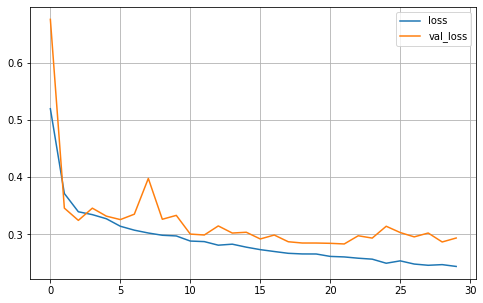

In [11]:
model_df.plot(figsize=(8,5))
plt.grid(True)
plt.show()